In [3]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from beamformer import util
from beamformer import minimum_variance_distortionless_response as mvdr
from scipy.io import wavfile
from calculatePos3d import calculatePos3d
import pandas as pd 


In [9]:
def make_mono_audio(frequency: int, write_file: bool = False, duration: float = 1.0, sampling_rate: int = 44100):
    """
    Generate a mono sine wave audio signal.

    :param frequency: Frequency of the sine wave in Hz.
    :param write_file: If True, saves the generated audio as a WAV file.
    :param duration: Duration of the generated sine wave in seconds (default: 1.0s).
    :param sampling_rate: Sampling rate in Hz (default: 44100 Hz).
    :return: NumPy array containing the generated sine wave.
    """
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    result = np.sin(2 * np.pi * frequency * t)

    if write_file:
        write("updated_sin1k.wav", sampling_rate, result.astype(np.float32))

    return result

In [10]:
# def create_delay_vector(speed_of_sound, angle_rad, num_mics, mic_separation):
#     """
#     Create a delay vector for microphone array beamforming.

#     :param speed_of_sound: Speed of sound in m/s.
#     :param angle_rad: Steering angle in radians.
#     :param num_mics: Number of microphones in the array.
#     :param mic_separation: Distance between adjacent microphones in meters.
#     :return: Delay vector for each microphone.
#     """
#     mic_positions = np.arange(num_mics) * mic_separation
#     delay_vector = -mic_positions * np.sin(angle_rad) / speed_of_sound
#     return delay_vector

# def set_steering_vector(delay_vector, signal_length, fs):
#     """
#     Generate a steering vector for phase shifting.

#     :param delay_vector: Delays for each microphone.
#     :param signal_length: Length of the mono audio signal.
#     :param fs: Sampling frequency in Hz.
#     :return: Steering vector for phase shifting.
#     """
#     freqs = np.fft.rfftfreq(signal_length, d=1/fs)
#     steering_vector = np.exp(-1j * 2 * np.pi * np.outer(freqs, delay_vector))
#     return steering_vector

# def delay_across_channels_py_freq(mono_audio, steering_angle, num_mics, mic_separation, fs, speed_of_sound=343.0):
#     """
#     Delays a mono audio signal across multiple microphones in the frequency domain.

#     :param mono_audio: Input mono audio signal (NumPy array).
#     :param steering_angle: Desired steering angle in degrees.
#     :param num_mics: Number of microphones in the array.
#     :param mic_separation: Distance between adjacent microphones in meters.
#     :param fs: Sampling frequency in Hz.
#     :param speed_of_sound: Speed of sound in m/s (default: 343 m/s).
#     :return: Delayed multi-channel audio signal (NumPy array).
#     """
#     if mono_audio.ndim == 1:
#         mono_audio = mono_audio[:, np.newaxis]  # Ensure column vector
#     if num_mics <= 0:
#         raise ValueError("Number of microphones must be greater than 0!")

#     steering_angle = -steering_angle  # Reverse angle for correct steering calculations

#     # FFT of the mono audio
#     mono_audio_f = np.fft.rfft(mono_audio, axis=0)

#     # Create an empty ydelay matrix
#     ydelay = np.tile(mono_audio_f, (1, num_mics))  # Replicate signal across microphones

#     # Convert angle to radians
#     angle_rad = np.radians(steering_angle)

#     # Compute delays and steering vector
#     delay = create_delay_vector(speed_of_sound, angle_rad, num_mics, mic_separation)
#     steering_vector = set_steering_vector(delay, len(mono_audio), fs)

#     # Apply phase shifts
#     ydelay[:len(mono_audio_f)-1, :] *= steering_vector.T

#     # Inverse FFT to get the time-domain signal
#     result = np.fft.irfft(ydelay, axis=0)

#     return result

def create_delay_vector(speed_of_sound, angle_rad, num_mics, mic_separation):
    """
    Create a delay vector for microphone array beamforming.

    :param speed_of_sound: Speed of sound in m/s.
    :param angle_rad: Steering angle in radians.
    :param num_mics: Number of microphones in the array.
    :param mic_separation: Distance between adjacent microphones in meters.
    :return: Delay vector for each microphone.
    """
    mic_positions = np.arange(num_mics) * mic_separation
    delay_vector = -mic_positions * np.sin(angle_rad) / speed_of_sound
    return delay_vector

def set_steering_vector(delay_vector, signal_length, fs):
    """
    Generate a steering vector for phase shifting.

    :param delay_vector: Delays for each microphone.
    :param signal_length: Length of the mono audio signal.
    :param fs: Sampling frequency in Hz.
    :return: Steering vector for phase shifting.
    """
    freqs = np.fft.rfftfreq(signal_length, d=1/fs)
    steering_vector = np.exp(-1j * 2 * np.pi * freqs[:, np.newaxis] * delay_vector)
    return steering_vector

def delay_across_channels_py_freq(mono_audio, steering_angle, num_mics, mic_separation, fs, speed_of_sound=343.0):
    """
    Delays a mono audio signal across multiple microphones in the frequency domain.

    :param mono_audio: Input mono audio signal (NumPy array).
    :param steering_angle: Desired steering angle in degrees.
    :param num_mics: Number of microphones in the array.
    :param mic_separation: Distance between adjacent microphones in meters.
    :param fs: Sampling frequency in Hz.
    :param speed_of_sound: Speed of sound in m/s (default: 343 m/s).
    :return: Delayed multi-channel audio signal (NumPy array).
    """
    if mono_audio.ndim == 1:
        mono_audio = mono_audio[:, np.newaxis]  # Ensure column vector
    if num_mics <= 0:
        raise ValueError("Number of microphones must be greater than 0!")

    steering_angle = -steering_angle  # Reverse angle for correct steering calculations

    # FFT of the mono audio
    mono_audio_f = np.fft.rfft(mono_audio, axis=0)

    # Create an empty ydelay matrix
    ydelay = np.tile(mono_audio_f, (1, num_mics))  # Replicate signal across microphones

    # Convert angle to radians
    angle_rad = np.radians(steering_angle)

    # Compute delays and steering vector
    delay = create_delay_vector(speed_of_sound, angle_rad, num_mics, mic_separation)
    steering_vector = set_steering_vector(delay, len(mono_audio), fs)

    # Apply phase shifts (fixing broadcasting issue)
    ydelay *= steering_vector  # No transposition needed

    # Inverse FFT to get the time-domain signal
    result = np.fft.irfft(ydelay, axis=0)

    return result

In [6]:
mono_audio = make_mono_audio(1000,False,5,44100)
SAMPLING_FREQUENCY = 44100
FFT_LENGTH = 1024
FFT_SHIFT = 512
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 0
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)


max angle was at -89.27855711422846 and value is 1.538461685180664


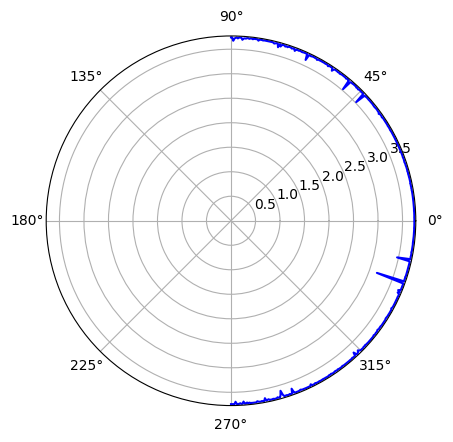

In [7]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,44100,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

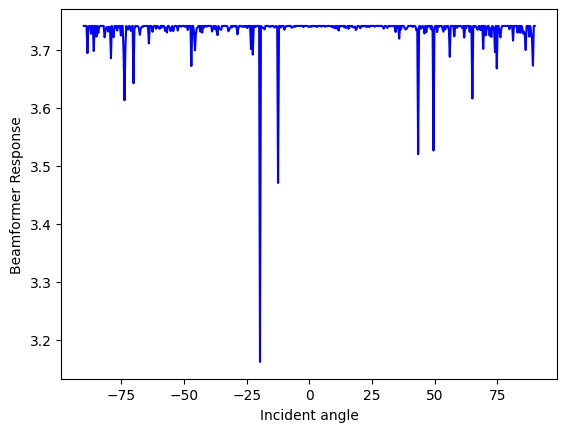

In [8]:


plt.xlabel("Incident angle")
plt.ylabel("Beamformer Response")
plt.plot(angleArr,logOutputArr,"b-")
plt.show()

In [9]:
mono_audio = make_mono_audio(5000,False,5,44100)
SAMPLING_FREQUENCY = 44100
FFT_LENGTH = 1024
FFT_SHIFT = 512
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 0
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)


max angle was at -89.27855711422846 and value is 1.538461685180664


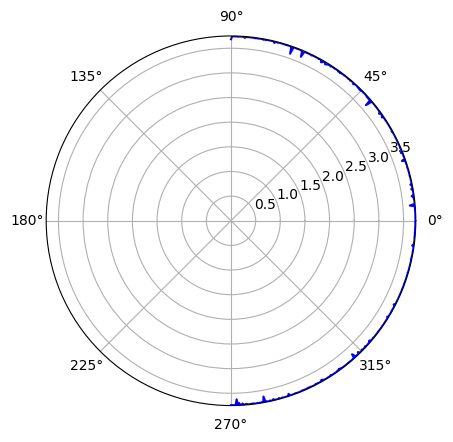

In [10]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,44100,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

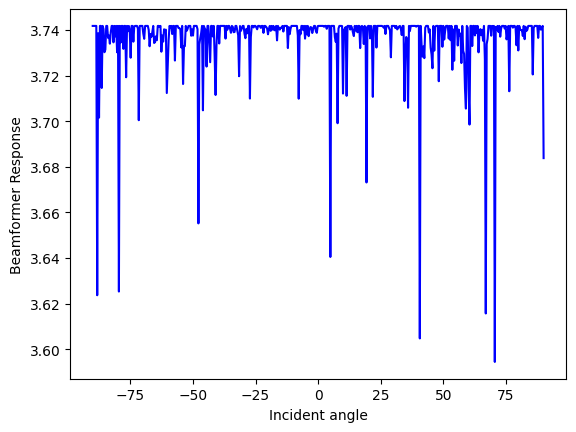

In [11]:
plt.xlabel("Incident angle")
plt.ylabel("Beamformer Response")
plt.plot(angleArr,logOutputArr,"b-")
plt.show()

In [12]:
mono_audio = make_mono_audio(12000,False,5,44100)
SAMPLING_FREQUENCY = 44100
FFT_LENGTH = 1024
FFT_SHIFT = 512
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 0
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)


max angle was at -89.27855711422846 and value is 1.538461685180664


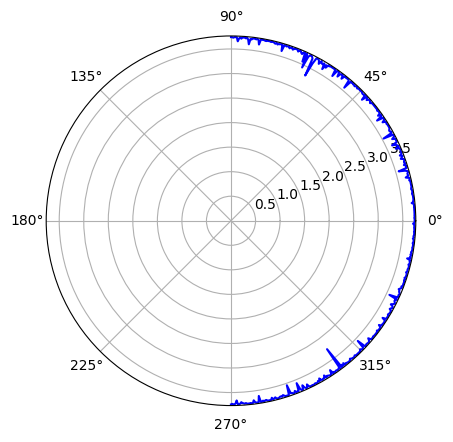

In [13]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,44100,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

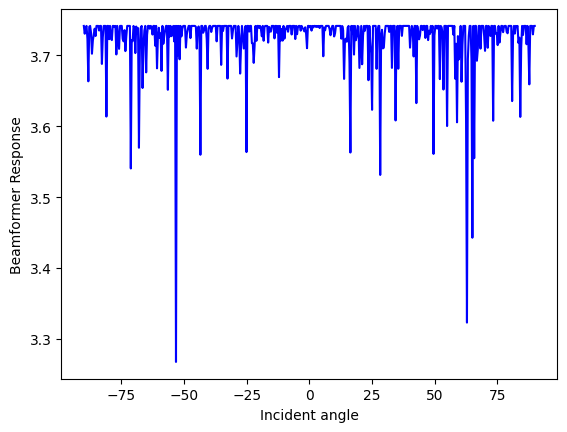

In [14]:
plt.xlabel("Incident angle")
plt.ylabel("Beamformer Response")
plt.plot(angleArr,logOutputArr,"b-")
plt.show()

In [15]:
mono_audio = make_mono_audio(12000,False,5,85000)
SAMPLING_FREQUENCY = 85000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 0
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)


max angle was at -88.55711422845691 and value is 1.538461685180664


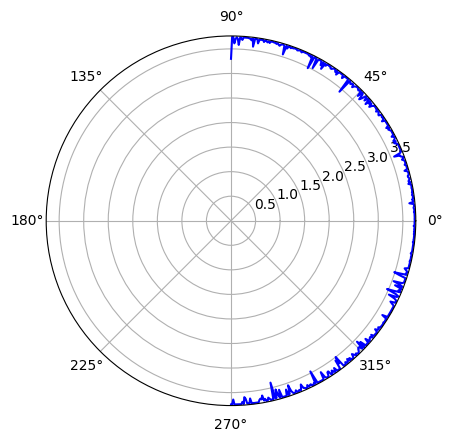

In [16]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,85000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

In [17]:
mono_audio = make_mono_audio(7000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 0
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)




/Users/mnara/Developer/cmono_beamform/beamformer/minimum_variance_distortionless_response.py:209: RuntimeWarning: divide by zero encountered in divide
  beamformer[:, f] = np.matmul(inv_R, steering_vector[:, f]) / b # number_of_mic *1   = number_of_mic *1 vector/scalar
/Users/mnara/Developer/cmono_beamform/beamformer/minimum_variance_distortionless_response.py:209: RuntimeWarning: invalid value encountered in divide
  beamformer[:, f] = np.matmul(inv_R, steering_vector[:, f]) / b # number_of_mic *1   = number_of_mic *1 vector/scalar
/Users/mnara/Developer/cmono_beamform/beamformer/minimum_variance_distortionless_response.py:224: RuntimeWarning: invalid value encountered in matmul
  enhanced_spectrum[:, f] = np.matmul(np.conjugate(beamformer[:, f]).T, complex_spectrum[:, :, f])


max angle was at -86.03206412825651 and value is 1.538461685180664


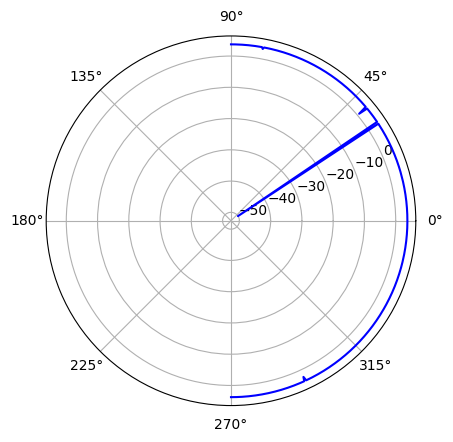

In [18]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()



In [ ]:
mono_audio = make_mono_audio(5000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 45
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)

max angle was at -89.27855711422846 and value is 1.538461685180664


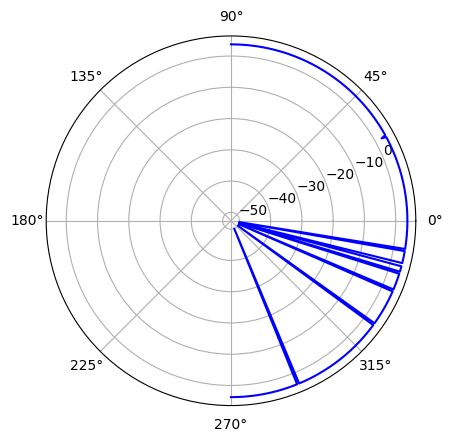

In [20]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

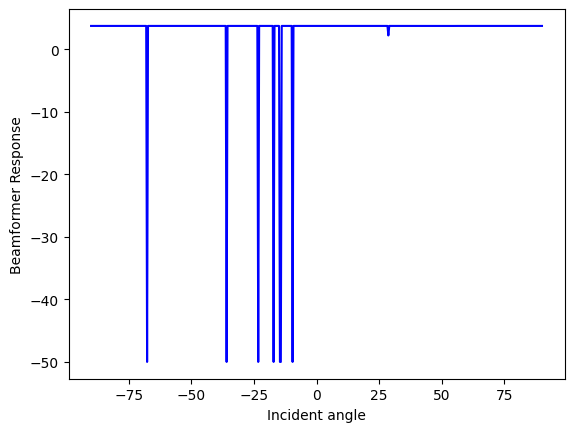

In [21]:
plt.xlabel("Incident angle")
plt.ylabel("Beamformer Response")
plt.plot(angleArr,logOutputArr,"b-")
plt.show()

In [22]:
mono_audio = make_mono_audio(1000,False,5,44100)
SAMPLING_FREQUENCY = 44100
FFT_LENGTH = 1024
FFT_SHIFT = 512
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 0
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)


max angle was at -89.27855711422846 and value is 1.538461685180664


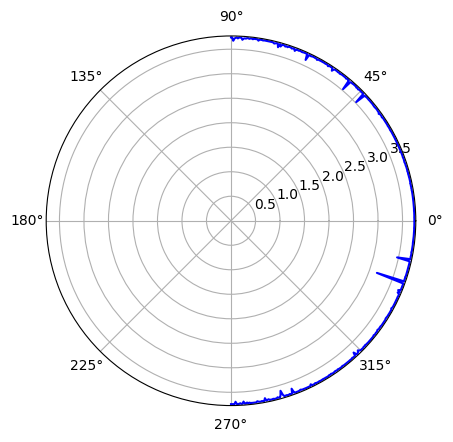

In [23]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,44100,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

In [24]:
mono_audio = make_mono_audio(5000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 10
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)

max angle was at -89.63927855711422 and value is 1.538461685180664


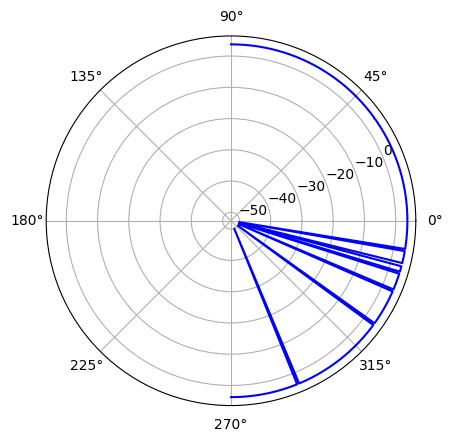

In [25]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

In [26]:
mono_audio = make_mono_audio(5000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 50
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)

max angle was at -90.0 and value is 1.538461685180664


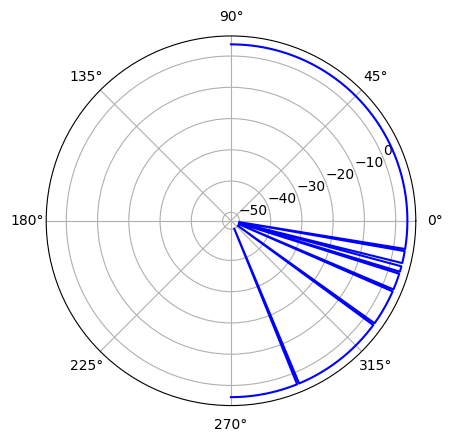

In [27]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

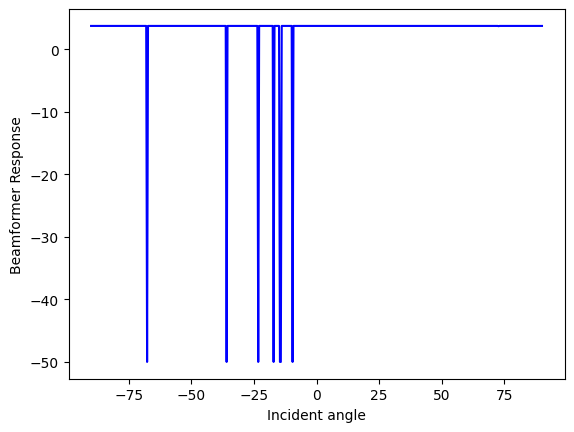

In [28]:
plt.xlabel("Incident angle")
plt.ylabel("Beamformer Response")
plt.plot(angleArr,logOutputArr,"b-")
plt.show()

In [29]:
mono_audio = make_mono_audio(5000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
#MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
#LOOK_DIRECTION = 90
#MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 215
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr.minimum_variance_distortioless_response(m, SAMPLING_FREQUENCY, c, FFT_LENGTH, FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector2(s)

max angle was at -89.27855711422846 and value is 1.538461685180664


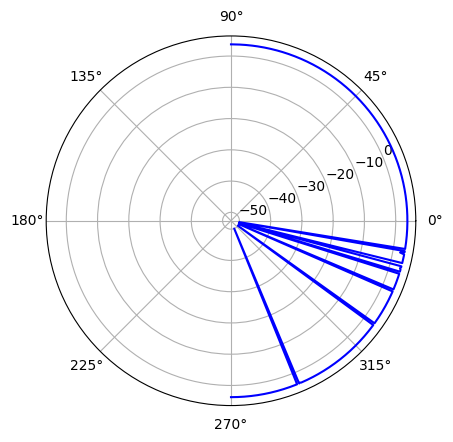

In [30]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix1(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer1(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer1(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

##old version


In [31]:
from beamformer import minimum_variance_distortionless_response2 as mvdr1


In [32]:
mono_audio = make_mono_audio(5000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
MIC_ANGLE_VECTOR = np.array([0,0,0,0,0,0,0,0])
LOOK_DIRECTION = 0 #deg
MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 45
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr1.minimum_variance_distortioless_response(MIC_ANGLE_VECTOR, D, sampling_frequency=SAMPLING_FREQUENCY, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector1(LOOK_DIRECTION)


/Users/mnara/Developer/cmono_beamform/beamformer/minimum_variance_distortionless_response2.py:199: RuntimeWarning: divide by zero encountered in divide
  beamformer[:, f] = np.matmul(inv_R, steering_vector[:, f]) / b # number_of_mic *1   = number_of_mic *1 vector/scalar
/Users/mnara/Developer/cmono_beamform/beamformer/minimum_variance_distortionless_response2.py:199: RuntimeWarning: invalid value encountered in divide
  beamformer[:, f] = np.matmul(inv_R, steering_vector[:, f]) / b # number_of_mic *1   = number_of_mic *1 vector/scalar
/Users/mnara/Developer/cmono_beamform/beamformer/minimum_variance_distortionless_response2.py:221: RuntimeWarning: invalid value encountered in matmul
  enhanced_spectrum[:, f] = np.matmul(np.conjugate(beamformer[:, f]).T, complex_spectrum[:, :, f])


max angle was at -89.63927855711422 and value is 1.538461685180664


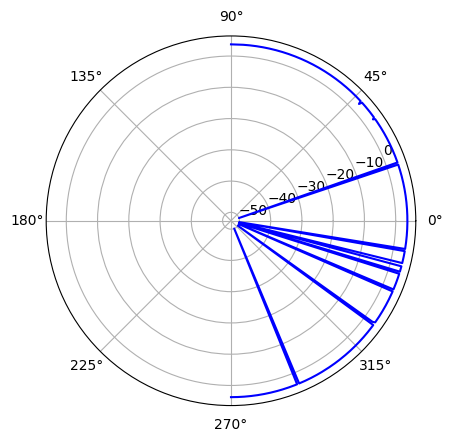

In [33]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH) #for multi channel fft
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix(audio) #correlation matrix

    beamformer = mvdr_beamformer.get_mvdr_beamformer(steering_vector, spatial_correlation_matrix) #applying beamforming (convolution function)

    enhanced_speech = mvdr_beamformer.apply_beamformer(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65) #normalization




#polar plotting (Agular sweep)
    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

In [34]:
mono_audio = make_mono_audio(5000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
MIC_ANGLE_VECTOR = np.array([4,3,1.75,0.6,0.6,1.75,3,4])
LOOK_DIRECTION = 0
MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 45
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr1.minimum_variance_distortioless_response(MIC_ANGLE_VECTOR, D, sampling_frequency=SAMPLING_FREQUENCY, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector1(LOOK_DIRECTION)


max angle was at -89.63927855711422 and value is 1.538461685180664


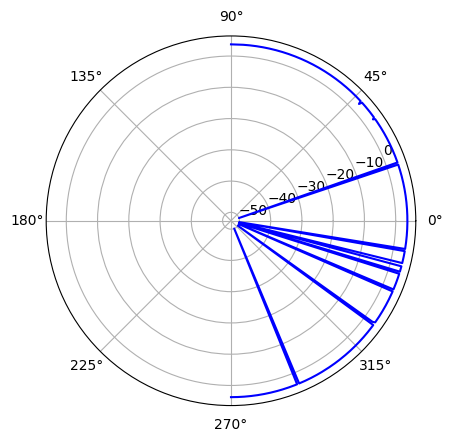

In [35]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

In [36]:
mono_audio = make_mono_audio(5000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
MIC_ANGLE_VECTOR = np.array([4,3,1.75,0.6,0.6,1.75,3,4])
LOOK_DIRECTION = 45
MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 45
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr1.minimum_variance_distortioless_response(MIC_ANGLE_VECTOR, D, sampling_frequency=SAMPLING_FREQUENCY, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector1(LOOK_DIRECTION)


max angle was at -89.27855711422846 and value is 1.538461685180664


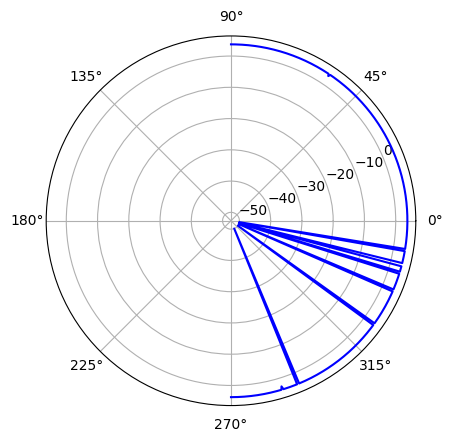

In [37]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

In [38]:
mono_audio = make_mono_audio(5000,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
MIC_ANGLE_VECTOR = np.array([4,3,1.75,0.6,0.6,1.75,3,4])
LOOK_DIRECTION = 63
MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 45
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr1.minimum_variance_distortioless_response(MIC_ANGLE_VECTOR, D, sampling_frequency=SAMPLING_FREQUENCY, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT)

steering_vector = mvdr_beamformer.get_sterring_vector1(LOOK_DIRECTION)


max angle was at -90.0 and value is 1.538461685180664


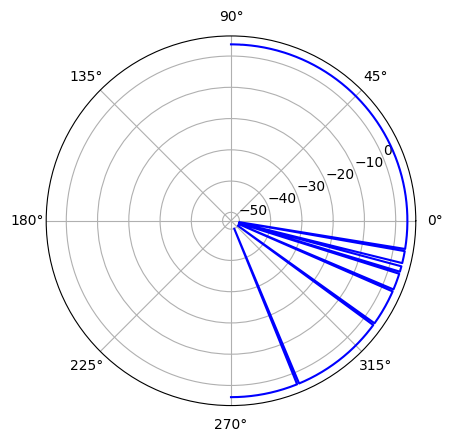

In [39]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

In [40]:
mono_audio = make_mono_audio(500,False,5,16000)
SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
#ENHANCED_WAV_NAME = './output/enhanced_speech_mvdr.wav'
MIC_ANGLE_VECTOR = np.array([4,3,1.75,0.6,0.6,1.75,3,4])
LOOK_DIRECTION = 25
MIC_DIAMETER = 0.1
c = 343
D = 0.01
M  = 8
theta = 80
s,m = calculatePos3d(D,M,theta)
mvdr_beamformer = mvdr1.minimum_variance_distortioless_response(MIC_ANGLE_VECTOR, D, sampling_frequency=SAMPLING_FREQUENCY, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT)
#new_data = delay_across_channels_py_freq(mono_audio,LOOK_DIRECTION,M,D,16000)
steering_vector = mvdr_beamformer.get_sterring_vector1(LOOK_DIRECTION)


max angle was at -89.63927855711422 and value is 1.538461685180664


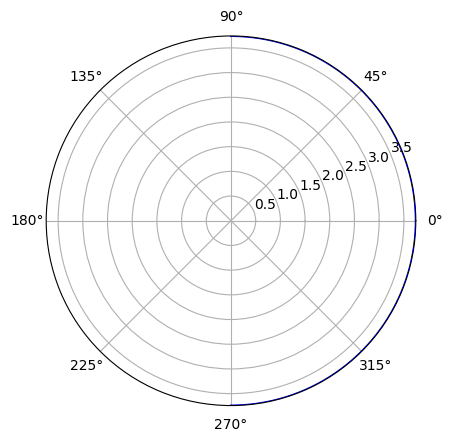

In [41]:
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,0.01,16000,343)
    # ds.reset_audio(audio)
    # ds.set_steering_vector(delay)
    # beamformed_audio = ds.apply_steering_vector()
    # scaled_audio = beamformed_audio
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(audio, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix(audio)

    beamformer = mvdr_beamformer.get_mvdr_beamformer(steering_vector, spatial_correlation_matrix)

    enhanced_speech = mvdr_beamformer.apply_beamformer(beamformer, complex_spectrum)

    normalized_speech = enhanced_speech / (np.max(np.abs(enhanced_speech))*0.65)


    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
   
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    # print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()
# else:
#     plt.xlabel("Incident angle")
#     plt.ylabel("Beamformer Response")
#     plt.plot(angleArr,logOutputArr,"b-")
#     plt.show()

In [42]:
mono_audio = make_mono_audio(8000,False,5,44100)


In [43]:
import numpy as np
import soundfile as sf                          # pip install soundfile
from scipy.signal import stft, istft

# ------------------------ Array & signal parameters ------------------------
c               = 343.0                         # speed of sound (m/s)
#fs, sig         = sf.read("8ch_recording.wav")  # sig → shape (samples , 8)
M               = 8                # = 8
win_len         = 1024                          # STFT window size
hop             = win_len // 2
window          = "hann"
fs = 44100

# ----------- ❶ steering vector for the desired look-direction --------------
# Example: linear array, d = 4 cm spacing, plane-wave from broadside (0°)
d               = 0.04
angles_deg      = 0                             # target azimuth (change as needed)
angles_rad      = np.deg2rad(angles_deg)
mic_positions   = np.arange(M) * d              # x-coordinates along array


f               = np.fft.rfftfreq(win_len, 1/fs)   # shape (F,)
# steering vector a(f) → shape (F , M)
ster = np.exp(-1j * (2*np.pi*f[:,None]) * mic_positions[None,:] * np.cos(angles_rad) / c)

# ster = np.exp(-1j * 2*np.pi*f[:,None] * mic_positions[None,:]
#                 * np.cos(np.deg2rad(angles_deg)) / c)


max angle was at 82.06412825651302 and value is 0.13387752068824646


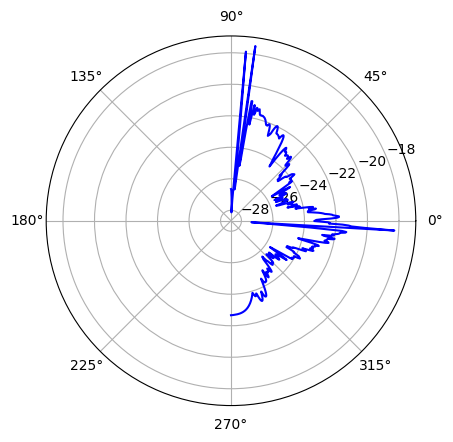

In [44]:
mono_audio = make_mono_audio(8000,False,5,44100)
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,d,fs,343)
    F, T, X = stft(audio.T, fs=fs, window=window, nperseg=win_len, noverlap=hop, axis=-1)
    # X shape: (M , F , T)

    # ---- ❸ estimate spatial covariance of noise R_n(f)  ----------------------
    # Simple approach: use initial 0.5 s as “noise-only”; improve with VAD if needed
    noise_samples   = int(0.5 * fs)
    _, _, X_noise   = stft(audio[:noise_samples].T, fs=fs, window=window,
                        nperseg=win_len, noverlap=hop, axis=-1)
    Rn = np.einsum("mft,nft->fmn", X_noise, np.conj(X_noise)) / X_noise.shape[-1]  # (F,M,M)

    # ❹ MVDR weights  w(f) = R_n⁻¹ a / (aᴴ R_n⁻¹ a)
    w = np.empty_like(ster, dtype=np.complex128)        # (F , M)
    X = X.transpose(1, 0, 2)

    for k in range(len(f)):
        R_inv_a          = np.linalg.solve(Rn[k] + 1e-6*np.eye(M), ster[k])   # regularised
        denom            = np.conj(ster[k]).T @ R_inv_a
        w[k]             = R_inv_a / denom

    # ---------------- ❺ apply beam-former & reconstruct -----------------------
    # Y = np.sum(np.conj(w[...,None]) * X, axis=0)     # (F , T)
    Y = np.sum(np.conj(w)[:, :, None] * X, axis=1)   # result (F , T)

    _, y_time = istft(Y, fs=fs, window=window, nperseg=win_len, noverlap=hop)
    
    normalized_speech =  np.abs(y_time)
    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
    
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    #print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()


In [45]:
import numpy as np
import soundfile as sf                          # pip install soundfile
from scipy.signal import stft, istft

# ------------------------ Array & signal parameters ------------------------
c               = 343.0                         # speed of sound (m/s)
#fs, sig         = sf.read("8ch_recording.wav")  # sig → shape (samples , 8)
M               = 8                # = 8
win_len         = 1024                          # STFT window size
hop             = win_len // 2
window          = "ham"
fs = 44100

# ----------- ❶ steering vector for the desired look-direction --------------
# Example: linear array, d = 4 cm spacing, plane-wave from broadside (0°)
d               = 0.04
angles_deg      = 0                             # target azimuth (change as needed)
angles_rad      = np.deg2rad(angles_deg)
mic_positions   = np.arange(M) * d              # x-coordinates along array


f               = np.fft.rfftfreq(win_len, 1/fs)   # shape (F,)
# steering vector a(f) → shape (F , M)
#ster = np.exp(-1j * (2*np.pi*f[:,None]) * mic_positions[None,:] * np.cos(angles_rad) / c)

ster = np.exp(-1j * 2*np.pi*f[:,None] * mic_positions[None,:]
                * np.cos(np.deg2rad(angles_deg)) / c)


max angle was at 89.27855711422845 and value is 1.0285899974161445


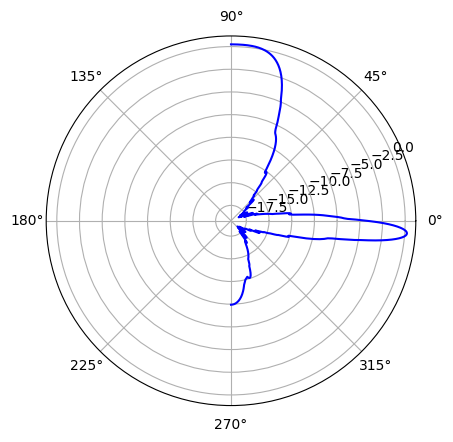

In [46]:
mono_audio = make_mono_audio(8000,False,5,44100)
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,d,fs,343)
    F, T, X = stft(audio.T, fs=fs, window=window, nperseg=win_len, noverlap=hop, axis=-1)
    # X shape: (M , F , T)

    # ---- ❸ estimate spatial covariance of noise R_n(f)  ----------------------
    # Simple approach: use initial 0.5 s as “noise-only”; improve with VAD if needed
    # noise_samples   = int(0.5 * fs)
    # _, _, X_noise   = stft(audio[:noise_samples].T, fs=fs, window=window,
    #                     nperseg=win_len, noverlap=hop, axis=-1)
    # Rn = np.einsum("mft,nft->fmn", X_noise, np.conj(X_noise)) / X_noise.shape[-1]  # (F,M,M)

    Rn = np.tile(np.eye(M), (len(f), 1, 1))                       # (F , M , M)

    # ---- MVDR weights --------------------------------------------------------
    w = np.empty_like(ster, dtype=np.complex128)
    for k in range(len(f)):
        R_inv_a = np.linalg.solve(Rn[k] + 1e-6*np.eye(M), ster[k])
        w[k]    = R_inv_a / (ster[k].conj() @ R_inv_a)
    # ❹ MVDR weights  w(f) = R_n⁻¹ a / (aᴴ R_n⁻¹ a)
    w = np.empty_like(ster, dtype=np.complex128)        # (F , M)
    X = X.transpose(1, 0, 2)

    for k in range(len(f)):
        R_inv_a          = np.linalg.solve(Rn[k] + 1e-6*np.eye(M), ster[k])   # regularised
        denom            = np.conj(ster[k]).T @ R_inv_a
        w[k]             = R_inv_a / denom

    # ---------------- ❺ apply beam-former & reconstruct -----------------------
    # Y = np.sum(np.conj(w[...,None]) * X, axis=0)     # (F , T)
    Y = np.sum(np.conj(w)[:, :, None] * X, axis=1)   # result (F , T)

    _, y_time = istft(Y, fs=fs, window=window, nperseg=win_len, noverlap=hop)
    
    normalized_speech =  np.abs(y_time)
    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
    
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    #print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()


In [47]:
import numpy as np
import soundfile as sf                          # pip install soundfile
from scipy.signal import stft, istft

# ------------------------ Array & signal parameters ------------------------
c               = 343.0                         # speed of sound (m/s)
#fs, sig         = sf.read("8ch_recording.wav")  # sig → shape (samples , 8)
M               = 8                # = 8
win_len         = 1024                          # STFT window size
hop             = win_len // 2
window          = "ham"
fs = 44100

# ----------- ❶ steering vector for the desired look-direction --------------
# Example: linear array, d = 4 cm spacing, plane-wave from broadside (0°)
d               = 0.04
angles_deg      = 30                         # target azimuth (change as needed)
angles_rad      = np.deg2rad(angles_deg)
mic_positions   = np.arange(M) * d              # x-coordinates along array


f               = np.fft.rfftfreq(win_len, 1/fs)   # shape (F,)
# steering vector a(f) → shape (F , M)
#ster = np.exp(-1j * (2*np.pi*f[:,None]) * mic_positions[None,:] * np.cos(angles_rad) / c)

ster = np.exp(-1j * 2*np.pi*f[:,None] * mic_positions[None,:]
                * np.cos(np.deg2rad(angles_deg)) / c)


max angle was at 60.060120240480956 and value is 1.0249850271332948


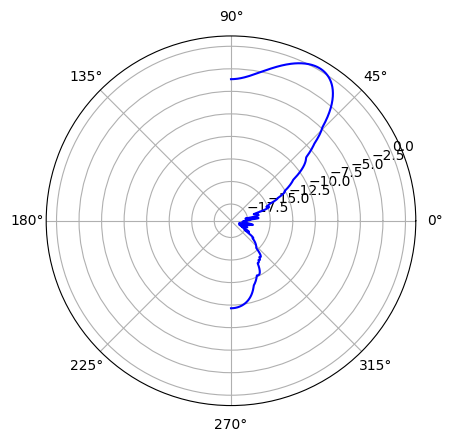

In [48]:
mono_audio = make_mono_audio(4000,False,5,44100)
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,d,fs,343)
    F, T, X = stft(audio.T, fs=fs, window=window, nperseg=win_len, noverlap=hop, axis=-1)
    # X shape: (M , F , T)

    # ---- ❸ estimate spatial covariance of noise R_n(f)  ----------------------
    # Simple approach: use initial 0.5 s as “noise-only”; improve with VAD if needed
    # noise_samples   = int(0.5 * fs)
    # _, _, X_noise   = stft(audio[:noise_samples].T, fs=fs, window=window,
    #                     nperseg=win_len, noverlap=hop, axis=-1)
    # Rn = np.einsum("mft,nft->fmn", X_noise, np.conj(X_noise)) / X_noise.shape[-1]  # (F,M,M)

    Rn = np.tile(np.eye(M), (len(f), 1, 1))                       # (F , M , M)

    # ---- MVDR weights --------------------------------------------------------
    w = np.empty_like(ster, dtype=np.complex128)
    for k in range(len(f)):
        R_inv_a = np.linalg.solve(Rn[k] + 1e-6*np.eye(M), ster[k])
        w[k]    = R_inv_a / (ster[k].conj() @ R_inv_a)
    # ❹ MVDR weights  w(f) = R_n⁻¹ a / (aᴴ R_n⁻¹ a)
    w = np.empty_like(ster, dtype=np.complex128)        # (F , M)
    X = X.transpose(1, 0, 2)

    for k in range(len(f)):
        R_inv_a          = np.linalg.solve(Rn[k] + 1e-6*np.eye(M), ster[k])   # regularised
        denom            = np.conj(ster[k]).T @ R_inv_a
        w[k]             = R_inv_a / denom

    # ---------------- ❺ apply beam-former & reconstruct -----------------------
    # Y = np.sum(np.conj(w[...,None]) * X, axis=0)     # (F , T)
    Y = np.sum(np.conj(w)[:, :, None] * X, axis=1)   # result (F , T)

    _, y_time = istft(Y, fs=fs, window=window, nperseg=win_len, noverlap=hop)
    
    normalized_speech =  np.abs(y_time)
    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
    
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    #print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()


In [49]:
import numpy as np
import soundfile as sf                          # pip install soundfile
from scipy.signal import stft, istft

# ------------------------ Array & signal parameters ------------------------
c               = 343.0                         # speed of sound (m/s)
#fs, sig         = sf.read("8ch_recording.wav")  # sig → shape (samples , 8)
M               = 8                # = 8
win_len         = 1024                          # STFT window size
hop             = win_len // 2
window          = "ham"
fs = 44100

# ----------- ❶ steering vector for the desired look-direction --------------
# Example: linear array, d = 4 cm spacing, plane-wave from broadside (0°)
d               = 0.04
angles_deg      = 45                           # target azimuth (change as needed)
angles_rad      = np.deg2rad(angles_deg)
mic_positions   = np.arange(M) * d              # x-coordinates along array


f               = np.fft.rfftfreq(win_len, 1/fs)   # shape (F,)
# steering vector a(f) → shape (F , M)
#ster = np.exp(-1j * (2*np.pi*f[:,None]) * mic_positions[None,:] * np.cos(angles_rad) / c)

ster = np.exp(-1j * 2*np.pi*f[:,None] * mic_positions[None,:]
                * np.cos(np.deg2rad(angles_deg)) / c)


In [1]:
mono_audio = make_mono_audio(700,False,5,fs)
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,d,fs,343)
    F, T, X = stft(audio.T, fs=fs, window=window, nperseg=win_len, noverlap=hop, axis=-1)
    # X shape: (M , F , T)

    # ---- ❸ estimate spatial covariance of noise R_n(f)  ----------------------
    # Simple approach: use initial 0.5 s as “noise-only”; improve with VAD if needed
    # noise_samples   = int(0.5 * fs)
    # _, _, X_noise   = stft(audio[:noise_samples].T, fs=fs, window=window,
    #                     nperseg=win_len, noverlap=hop, axis=-1)
    # Rn = np.einsum("mft,nft->fmn", X_noise, np.conj(X_noise)) / X_noise.shape[-1]  # (F,M,M)

    Rn = np.tile(np.eye(M), (len(f), 1, 1))                       # (F , M , M)

    # ---- MVDR weights --------------------------------------------------------
    w = np.empty_like(ster, dtype=np.complex128)
    for k in range(len(f)):
        R_inv_a = np.linalg.solve(Rn[k] + 1e-6*np.eye(M), ster[k])
        w[k]    = R_inv_a / (ster[k].conj() @ R_inv_a)
    # ❹ MVDR weights  w(f) = R_n⁻¹ a / (aᴴ R_n⁻¹ a)
    w = np.empty_like(ster, dtype=np.complex128)        # (F , M)
    X = X.transpose(1, 0, 2)

    for k in range(len(f)):
        R_inv_a          = np.linalg.solve(Rn[k] + 1e-6*np.eye(M), ster[k])   # regularised
        denom            = np.conj(ster[k]).T @ R_inv_a
        w[k]             = R_inv_a / denom

    # ---------------- ❺ apply beam-former & reconstruct -----------------------
    # Y = np.sum(np.conj(w[...,None]) * X, axis=0)     # (F , T)
    Y = np.sum(np.conj(w)[:, :, None] * X, axis=1)   # result (F , T)

    _, y_time = istft(Y, fs=fs, window=window, nperseg=win_len, noverlap=hop)
    
    normalized_speech =  np.abs(y_time)
    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
    
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    #print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()


NameError: name 'make_mono_audio' is not defined

In [2]:
import numpy as np
import soundfile as sf                          # pip install soundfile
from scipy.signal import stft, istft

# ------------------------ Array & signal parameters ------------------------
c               = 343.0                         # speed of sound (m/s)
#fs, sig         = sf.read("8ch_recording.wav")  # sig → shape (samples , 8)
M               = 8                # = 8
win_len         = 1024                          # STFT window size
hop             = win_len // 2
window          = "ham"
fs = 44100

# ----------- ❶ steering vector for the desired look-direction --------------
# Example: linear array, d = 4 cm spacing, plane-wave from broadside (0°)
d               = 0.01
angles_deg      = 45                           # target azimuth (change as needed)
angles_rad      = np.deg2rad(angles_deg)
mic_positions   = np.arange(M) * d              # x-coordinates along array


f               = np.fft.rfftfreq(win_len, 1/fs)   # shape (F,)
# steering vector a(f) → shape (F , M)
#ster = np.exp(-1j * (2*np.pi*f[:,None]) * mic_positions[None,:] * np.cos(angles_rad) / c)

ster = np.exp(-1j * 2*np.pi*f[:,None] * mic_positions[None,:]
                * np.cos(np.deg2rad(angles_deg)) / c)


In [3]:
mono_audio = make_mono_audio(700,False,5,fs)
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,d,fs,343)
    F, T, X = stft(audio.T, fs=fs, window=window, nperseg=win_len, noverlap=hop, axis=-1)
    # X shape: (M , F , T)

    # ---- ❸ estimate spatial covariance of noise R_n(f)  ----------------------
    # Simple approach: use initial 0.5 s as “noise-only”; improve with VAD if needed
    # noise_samples   = int(0.5 * fs)
    # _, _, X_noise   = stft(audio[:noise_samples].T, fs=fs, window=window,
    #                     nperseg=win_len, noverlap=hop, axis=-1)
    # Rn = np.einsum("mft,nft->fmn", X_noise, np.conj(X_noise)) / X_noise.shape[-1]  # (F,M,M)

    Rn = np.tile(np.eye(M), (len(f), 1, 1))                       # (F , M , M) Covariance matrix

    # ---- MVDR weights --------------------------------------------------------
    w = np.empty_like(ster, dtype=np.complex128)
    for k in range(len(f)):
        R_inv_a = np.linalg.solve(Rn[k] + 1e-6*np.eye(M), ster[k])
        w[k]    = R_inv_a / (ster[k].conj() @ R_inv_a)
    # ❹ MVDR weights  w(f) = R_n⁻¹ a / (aᴴ R_n⁻¹ a)
    w = np.empty_like(ster, dtype=np.complex128)        # (F , M)
    X = X.transpose(1, 0, 2)

    for k in range(len(f)):
        R_inv_a          = np.linalg.solve(Rn[k] + 1e-6*np.eye(M), ster[k])   # regularised
        denom            = np.conj(ster[k]).T @ R_inv_a
        w[k]             = R_inv_a / denom

    # ---------------- ❺ apply beam-former & reconstruct -----------------------
    # Y = np.sum(np.conj(w[...,None]) * X, axis=0)     # (F , T)
    Y = np.sum(np.conj(w)[:, :, None] * X, axis=1)   # result (F , T)

    _, y_time = istft(Y, fs=fs, window=window, nperseg=win_len, noverlap=hop)
    
    normalized_speech =  np.abs(y_time)
    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
    
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)
    #print(a)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()


NameError: name 'make_mono_audio' is not defined

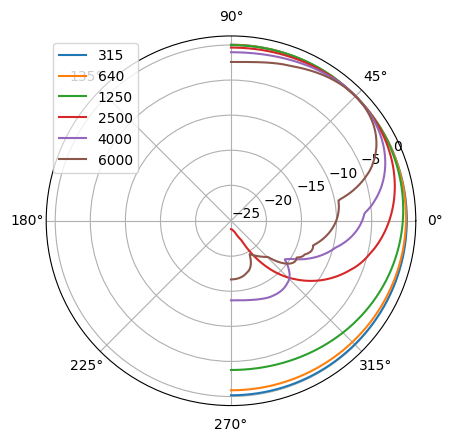

In [4]:
import numpy as np
import matplotlib.pyplot as plt

signal_freq = [315,640,1250,2500,4000,6000]
for i in signal_freq:
    ang = np.load(f'lee_res/angleRadArr_{i}.npy')
    log = np.load(f'lee_res/logOutputArr_{i}.npy')
    plt.polar(ang,log,label = f'{i}')
plt.legend()
plt.show()

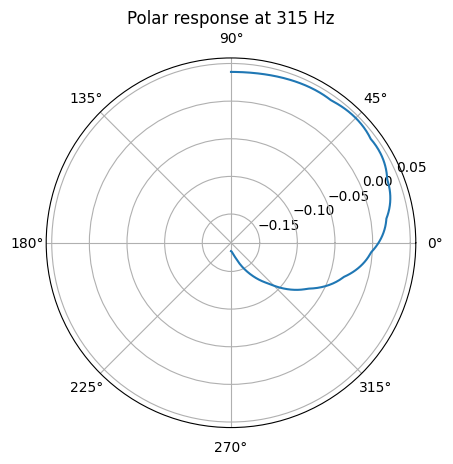

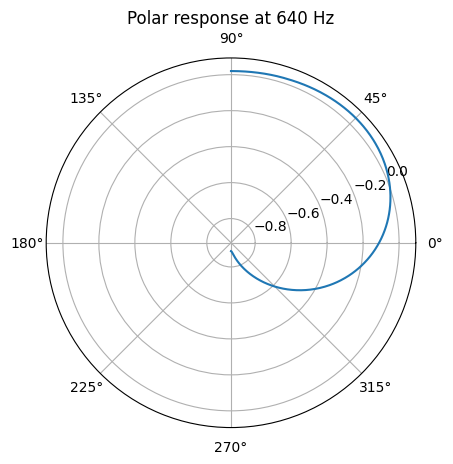

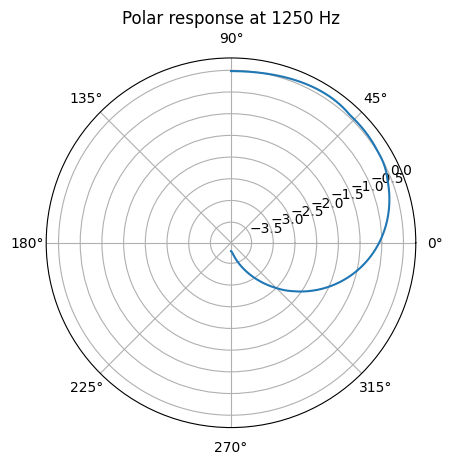

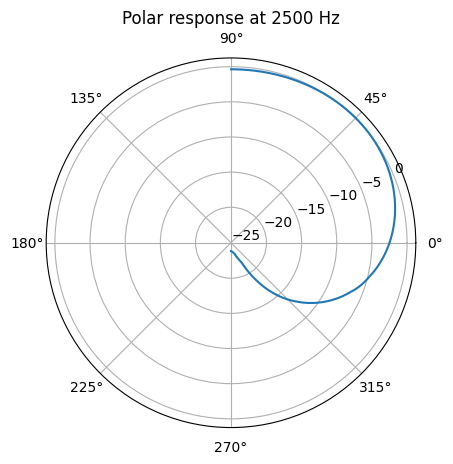

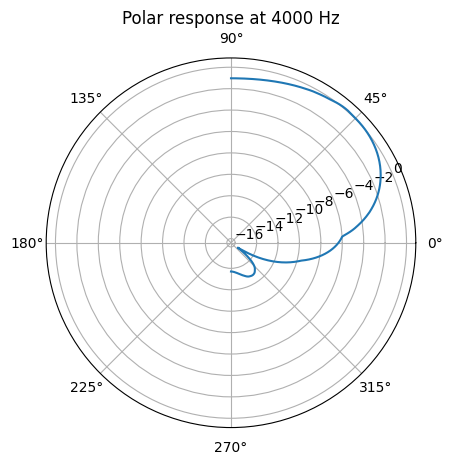

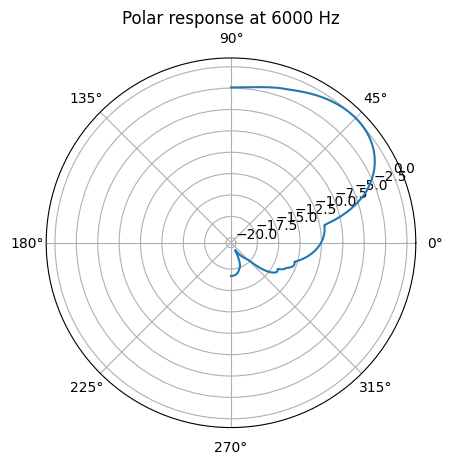

In [5]:
for freq in signal_freq:
    # load your data
    ang = np.load(f'lee_res/angleRadArr_{freq}.npy')
    log = np.load(f'lee_res/logOutputArr_{freq}.npy')
    
    # create a new figure for this frequency
    fig = plt.figure()
    ax  = fig.add_subplot(111, polar=True)
    
    # plot
    ax.plot(ang, log)
    ax.set_title(f'Polar response at {freq} Hz')
    
    # display
    plt.show()

max angle was at 45.27054108216433 and value is 0.30606217880823083


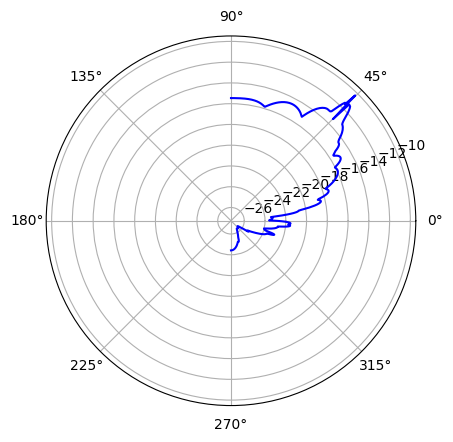

In [11]:
import numpy as np
from scipy.signal import stft, istft  
def make_mono_audio(frequency: int, write_file: bool = False, duration: float = 1.0, sampling_rate: int = 44100):
    """
    Generate a mono sine wave audio signal.

    :param frequency: Frequency of the sine wave in Hz.
    :param write_file: If True, saves the generated audio as a WAV file.
    :param duration: Duration of the generated sine wave in seconds (default: 1.0s).
    :param sampling_rate: Sampling rate in Hz (default: 44100 Hz).
    :return: NumPy array containing the generated sine wave.
    """
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    result = np.sin(2 * np.pi * frequency * t)

    if write_file:
        write("updated_sin1k.wav", sampling_rate, result.astype(np.float32))

    return result
  # ------------------------ Array & signal parameters ------------------------
i=12000
c               = 343.0                         # speed of sound (m/s)
#fs, sig         = sf.read("8ch_recording.wav")  # sig → shape (samples , 8)
M               = 8                # = 8
win_len         = 1024                          # STFT window size
hop             = win_len // 2
window          = "ham"
fs = 44100

# ----------- ❶ steering vector for the desired look-direction --------------
# Example: linear array, d = 4 cm spacing, plane-wave from broadside (0°)
d               = 0.01
angles_deg      = 45                           # target azimuth (change as needed)
angles_rad      = np.deg2rad(angles_deg)
mic_positions   = np.arange(M) * d              # x-coordinates along array


f               = np.fft.rfftfreq(win_len, 1/fs)   # shape (F,)
# steering vector a(f) → shape (F , M)
#ster = np.exp(-1j * (2*np.pi*f[:,None]) * mic_positions[None,:] * np.cos(angles_rad) / c)

ster = np.exp(-1j * 2*np.pi*f[:,None] * mic_positions[None,:]
                * np.cos(np.deg2rad(angles_deg)) / c)

mono_audio = make_mono_audio(i,False,5,fs)
angleArr = []
logOutputArr =[]
angleRadArr = []

maxAngle,maxVal = 0,-300
for a in range(500):
    angle = -90 + 180 * (a/(500-1))
    angleRad = angle * (np.pi/180)

    #audio = ss.delayAcrossChannelsPyFreq(np.array(monoAudio),angle,8,config["MIC_SPACING"],config["SAMPLING_FREQUENCY"])
    audio = delay_across_channels_py_freq(mono_audio,angle,8,d,fs,343)
    F, T, X = stft(audio.T, fs=fs, window=window, nperseg=win_len, noverlap=hop, axis=-1)
    # X shape: (M , F , T)

    # ---- ❸ estimate spatial covariance of noise R_n(f)  ----------------------
    # Simple approach: use initial 0.5 s as “noise-only”; improve with VAD if needed
    # noise_samples   = int(0.5 * fs)
    # _, _, X_noise   = stft(audio[:noise_samples].T, fs=fs, window=window,
    #                     nperseg=win_len, noverlap=hop, axis=-1)
    # Rn = np.einsum("mft,nft->fmn", X_noise, np.conj(X_noise)) / X_noise.shape[-1]  # (F,M,M)

    #Rn = np.tile(np.eye(M), (len(f), 1, 1))                       # (F , M , M) Covariance matrix# Select the first 0.5 seconds as a noise-only region (or use VAD)
    noise_samples = int(0.5 * fs)
    _, _, X_noise = stft(audio[:noise_samples].T, fs=fs, window=window, nperseg=win_len, noverlap=hop, axis=-1)

# Estimate noise spatial covariance matrix
    Rn = np.einsum("mft,nft->fmn", X_noise, np.conj(X_noise)) / X_noise.shape[-1]
    for k in range(len(f)):
        Rn[k] += 1e-6 * np.trace(Rn[k]) * np.eye(M) / M

    # ---- MVDR weights --------------------------------------------------------
    w = np.empty_like(ster, dtype=np.complex128)
    for k in range(len(f)):
        R_inv_a = np.linalg.solve(Rn[k] + 1e-6*np.eye(M), ster[k])
        w[k]    = R_inv_a / (ster[k].conj() @ R_inv_a)
    # ❹ MVDR weights  w(f) = R_n⁻¹ a / (aᴴ R_n⁻¹ a)
    w = np.empty_like(ster, dtype=np.complex128)        # (F , M)
    X = X.transpose(1, 0, 2)

    for k in range(len(f)):
        R_inv_a          = np.linalg.solve(Rn[k] + 1e-6*np.eye(M), ster[k])   # regularised
        denom            = np.conj(ster[k]).T @ R_inv_a
        w[k]             = R_inv_a / denom

    # ---------------- ❺ apply beam-former & reconstruct -----------------------
    # Y = np.sum(np.conj(w[...,None]) * X, axis=0)     # (F , T)
    Y = np.sum(np.conj(w)[:, :, None] * X, axis=1)   # result (F , T)

    _, y_time = istft(Y, fs=fs, window=window, nperseg=win_len, noverlap=hop)
    
    normalized_speech =  np.abs(y_time)
    if maxVal < np.max(np.abs(normalized_speech)):
        maxVal = np.max(np.abs(normalized_speech))
        maxAngle = angle
    
    output = np.max(normalized_speech) 
    logOutput = 20 * np.log10(output) if 20 * np.log10(output) >= -50 else -50
    angleRadArr.append(angleRad)
    angleArr.append(angle)
    logOutputArr.append(logOutput)

print(f"max angle was at {maxAngle} and value is {maxVal}")
#if config["POLAR"] == True:
plt.polar(angleRadArr,logOutputArr,"b-")
plt.show()


Estimated DOA = -47.8°  (true = 45.0°)


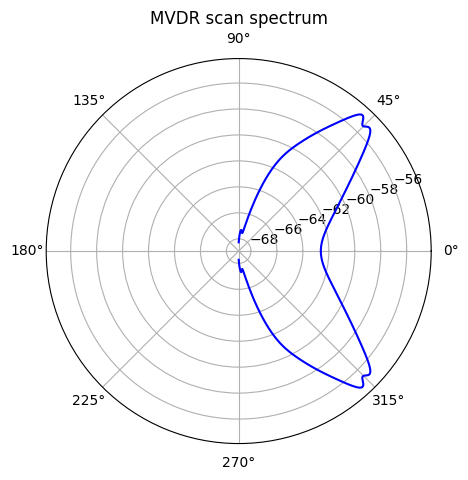

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft

"""
Run this script as‑is; it generates a synthetic 8‑mic recording of a 12 kHz tone
arriving from 45 ° azimuth, scans –90 … 90 ° with an MVDR beam‑former, and plots
the spatial spectrum.  No external beamforming libraries are required.
"""
# --------------------------------------------------------------------
# Configuration constants
# --------------------------------------------------------------------
FS          = 44_100              # Sampling frequency [Hz]
C           = 343.0               # Speed of sound [m/s]
ARRAY_SIZE  = 8                   # Number of microphones
MIC_SPACING = 0.01               # 1 cm spacing
WIN_LEN     = 1024                # STFT window length
HOP         = WIN_LEN // 2
WINDOW      = "ham"
SCAN_STEPS  = 500                 # Azimuth scan resolution
NOISE_SEC   = 0.5                 # Seconds to estimate noise covariance
EPS         = 1e-6                # Diagonal‑loading factor

# --------------------------------------------------------------------
# Utility functions
# --------------------------------------------------------------------

def make_mono_audio(freq: float, duration: float = 5.0, fs: int = FS) -> np.ndarray:
    """Return a sinusoid of *freq* Hz, *duration* s, sampled at *fs* Hz."""
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    return np.sin(2 * np.pi * freq * t)


def fractional_delay(x: np.ndarray, delay_samp: float) -> np.ndarray:
    """Fractionally delay *x* by *delay_samp* samples using linear interpolation."""
    n = np.arange(len(x))
    return np.interp(n - delay_samp, n, x, left=0.0, right=0.0)


def delay_across_channels_py_freq(sig_mono: np.ndarray, angle_deg: float, M: int,
                                  d: float, fs: float, c: float = C) -> np.ndarray:
    """Create an M‑channel recording of *sig_mono* delayed for a plane wave
    arriving from *angle_deg* (0° = broadside).

    Returns array with shape (N_samples, M).
    """
    theta = np.deg2rad(angle_deg)
    n_samples = len(sig_mono)
    out = np.zeros((n_samples, M))
    for m in range(M):
        delay_sec   = m * d * np.cos(theta) / c           # geometric delay
        delay_samp  = delay_sec * fs
        out[:, m]   = fractional_delay(sig_mono, delay_samp)
    return out


def steering_vector(theta_deg: float, freqs: np.ndarray) -> np.ndarray:
    """Steering vector a(f) with shape (F, M) for azimuth *theta_deg*."""
    theta = np.deg2rad(theta_deg)
    m_pos = np.arange(ARRAY_SIZE) * MIC_SPACING
    phase = -2j * np.pi * freqs[:, None] * m_pos[None, :] * np.cos(theta) / C
    return np.exp(phase)

# --------------------------------------------------------------------
# 1) Generate a single synthetic recording
# --------------------------------------------------------------------
TRUE_ANGLE = 45.0    # °
TONE_FREQ  = 12_000  # Hz

tone   = make_mono_audio(TONE_FREQ)
signal = delay_across_channels_py_freq(tone, TRUE_ANGLE, ARRAY_SIZE,
                                       MIC_SPACING, FS, C)  # (N, M)

# --------------------------------------------------------------------
# 2) STFT of the recording (once!)
# --------------------------------------------------------------------
freqs, times, X = stft(signal.T, fs=FS, window=WINDOW,
                       nperseg=WIN_LEN, noverlap=HOP, axis=-1)
X = X.transpose(1, 0, 2)  # → (F, M, T)

# --------------------------------------------------------------------
# 3) Estimate noise spatial covariance R_n(f)
# --------------------------------------------------------------------
noise_samples = int(NOISE_SEC * FS)
_, _, X_noise = stft(signal[:noise_samples].T, fs=FS, window=WINDOW,
                     nperseg=WIN_LEN, noverlap=HOP, axis=-1)
Rn = np.einsum("mft,nft->fmn", X_noise, np.conj(X_noise)) / X_noise.shape[-1]
for k in range(len(freqs)):
    Rn[k] += EPS * np.trace(Rn[k]) * np.eye(ARRAY_SIZE) / ARRAY_SIZE

# --------------------------------------------------------------------
# 4) Scan candidate directions with MVDR
# --------------------------------------------------------------------
angles_deg = np.linspace(-90, 90, SCAN_STEPS)
power_db   = []

for theta in angles_deg:
    a_theta  = steering_vector(theta, freqs)               # (F, M)
        # --- MVDR weights w(f) = R_n⁻¹ a / (aᴴ R_n⁻¹ a) ---------------------
    w_theta = np.empty_like(a_theta, dtype=np.complex128)  # (F, M)
    for k in range(len(freqs)):
        R_k = Rn[k] + EPS * np.eye(ARRAY_SIZE)             # stabilise each R_k
        a_k = a_theta[k]
        R_inv_a = np.linalg.solve(R_k, a_k)                # (M,)
        denom   = np.conj(a_k) @ R_inv_a                   # scalar
        w_theta[k] = R_inv_a / denom

    # --------------------------------------------------------------------
    # Apply beam‑former Y(f,t) = wᴴ(f) X(f,t)
    Y = np.sum(np.conj(w_theta)[:, :, None] * X, axis=1)   # (F, T)

    Y = np.sum(np.conj(w_theta)[:, :, None] * X, axis=1)   # (F, T)
    _, y_time = istft(Y, fs=FS, window=WINDOW, nperseg=WIN_LEN, noverlap=HOP)

    # Robust metric: RMS power
    p = np.mean(np.abs(y_time) ** 2)
    power_db.append(10 * np.log10(p + 1e-12))

power_db = np.array(power_db)
idx_max  = np.argmax(power_db)
print(f"Estimated DOA = {angles_deg[idx_max]:.1f}°  (true = {TRUE_ANGLE:.1f}°)")

# --------------------------------------------------------------------
# 5) Visualise MVDR spectrum
# --------------------------------------------------------------------
plt.figure(figsize=(5, 5))
# Clip –50 dB for readability
clip_floor = power_db.max() - 50
plt.polar(np.deg2rad(angles_deg), np.maximum(power_db, clip_floor), 'b-')
plt.title('MVDR scan spectrum')
plt.show()
